In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.layers import *
from keras import regularizers

from latent_evolution_model import PILE_v2
from latent_evolution_model import PILE_v3
from latent_evolution_model import LatentPARC_v2
from visualization import plot_latent_prediction


### PILE_v2

In [3]:
# data_path = '/home/jut6nm/PARC/Data/Processed_data/single_void_state/'
state_in = np.load(data_path + 'State_input_160_256.npy')
state_out = np.load(data_path + 'State_output_160_256.npy')
num_ts = np.load(data_path + 'number_timesteps.npy')
print((state_in.shape, state_out.shape, num_ts.shape))

((2871, 160, 256, 3), (2871, 160, 256, 3), (128,))


In [3]:
n_samples = 120
n = np.sum(num_ts[:n_samples]) - n_samples
data_train = [state_in[:n,:,:,:], state_out[:n,:,:,:]]
data_train[0].shape

(2668, 160, 256, 3)

In [23]:
f = 0
fields = ['temperature', 'pressure', 'microstructure']
state_ae = PILE_v2(fields[f], 16, (160, 256, 3), [1, 1, 1])
state_ae.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99))
state_ae.fit(data_train[0][:,:,:,f:f+1], data_train[1][:,:,:,f:f+1], batch_size = 8, epochs = 10, shuffle = True)

Epoch 1/10
334/334 [==============================] - 16s 21ms/step - total_loss: 1.9243 - in_ae_loss: 0.6380 - out_ae_loss: 0.6340 - latent_loss: 0.0144 - recon_loss: 0.6379
Epoch 2/10
334/334 [==============================] - 7s 21ms/step - total_loss: 0.0660 - in_ae_loss: 0.0217 - out_ae_loss: 0.0192 - latent_loss: 9.9685e-04 - recon_loss: 0.0241
Epoch 3/10
334/334 [==============================] - 7s 21ms/step - total_loss: 0.0361 - in_ae_loss: 0.0115 - out_ae_loss: 0.0096 - latent_loss: 7.3353e-04 - recon_loss: 0.0143
Epoch 4/10
334/334 [==============================] - 7s 20ms/step - total_loss: 0.0296 - in_ae_loss: 0.0093 - out_ae_loss: 0.0076 - latent_loss: 6.2290e-04 - recon_loss: 0.0121
Epoch 5/10
334/334 [==============================] - 7s 20ms/step - total_loss: 0.0251 - in_ae_loss: 0.0076 - out_ae_loss: 0.0062 - latent_loss: 5.4202e-04 - recon_loss: 0.0107
Epoch 6/10
334/334 [==============================] - 7s 20ms/step - total_loss: 0.0222 - in_ae_loss: 0.0066 - ou

In [27]:
getattr(state_ae, 'encoder_'+state_ae.field).save_weights('../NN_weights/encoder_'+state_ae.field+'.h5')
getattr(state_ae, 'decoder_'+state_ae.field).save_weights('../NN_weights/decoder_'+state_ae.field+'.h5')

In [5]:
f = 0
fields = ['temperature', 'pressure', 'microstructure']
state_ae = PILE_v2(fields[f], 16, (160, 256, 3), [1, 1, 1])
getattr(state_ae, 'encoder_'+state_ae.field).load_weights('../NN_weights/encoder_'+state_ae.field+'.h5')
getattr(state_ae, 'decoder_'+state_ae.field).load_weights('../NN_weights/decoder_'+state_ae.field+'.h5')

2024-01-27 13:52:28.647162: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78791 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:b7:00.0, compute capability: 8.0
2024-01-27 13:52:29.459773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904


In [7]:
sample = 45
n1 = np.sum(num_ts[:sample]) - sample
n2 = np.sum(num_ts[:sample+1]) - sample - 1
field_gt = state_in[n1:n2,:,:,f:f+1]
pred = state_ae.predict(field_gt)
pred.shape

(2, 21, 160, 256)

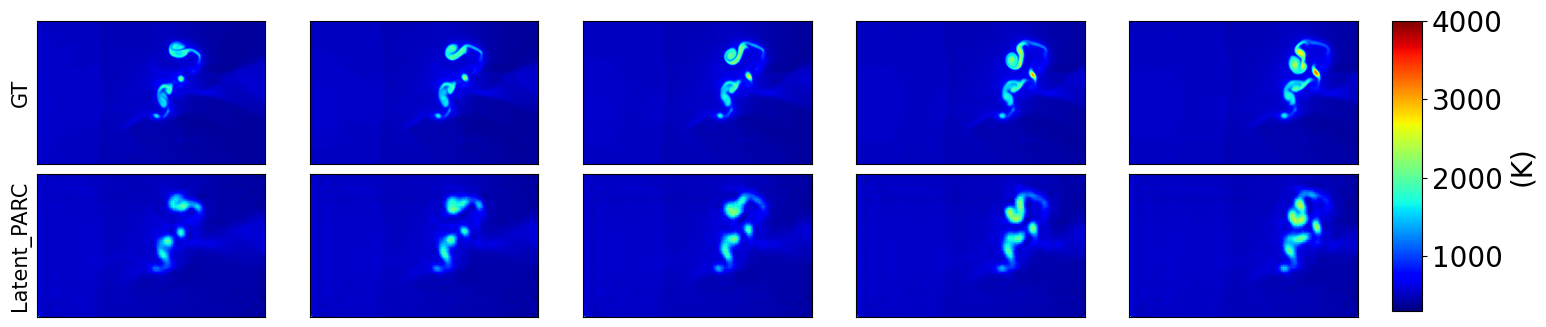

In [9]:
ae_fig = plot_latent_prediction(pred, fields[f], 10)

### PILE_v3

In [2]:
# data_path = '/home/jut6nm/PARC/Data/Processed_data/single_void_state/'
state_traj = np.load(data_path + 'state_160_256_20ts.npy')
state_traj.shape

(119, 160, 256, 3, 20)

In [68]:
f = 1
n_ts = 3
n_samples = 110
fields = ['temperature', 'pressure', 'microstructure']
for ts_idx in range(n_ts):
    data_in = []
    data_out = []
    for t in range (19-ts_idx):
        data_in.append(state_traj[:n_samples,:,:,f:f+1,t:t+1])
        data_out.append(state_traj[:n_samples,:,:,f:f+1,t+1:t+2+ts_idx])
    data_in = np.concatenate(data_in, axis=0)
    data_out = np.concatenate(data_out, axis=0)
    
    ###
    state_ae_v3 = PILE_v3(ts_idx+1, fields[f], 16, (160, 256, 3), [5, 2, 3])
    enc = getattr(state_ae_v3, 'encoder_'+state_ae_v3.field)
    dec = getattr(state_ae_v3, 'decoder_'+state_ae_v3.field)
    evol = state_ae_v3.latent_evolution
    if ts_idx > 0:
        enc.load_weights('../NN_weights/PILE_v3/' + state_ae_v3.field + '_encoder_' + str(ts_idx) + '_ts.h5')
        dec.load_weights('../NN_weights/PILE_v3/' + state_ae_v3.field + '_decoder_' + str(ts_idx) + '_ts.h5')
        evol.load_weights('../NN_weights/PILE_v3/' + state_ae_v3.field + '_evolution_' + str(ts_idx) + '_ts.h5')
        state_ae_v3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.5,beta_2=0.99))
        state_ae_v3.fit(data_in, data_out, batch_size = 16, epochs = 20, shuffle = True)
        enc.save_weights('../NN_weights/PILE_v3/' + state_ae_v3.field + '_encoder_' + str(ts_idx+1) + '_ts.h5')
        dec.save_weights('../NN_weights/PILE_v3/' + state_ae_v3.field + '_decoder_' + str(ts_idx+1) + '_ts.h5')
        evol.save_weights('../NN_weights/PILE_v3/' + state_ae_v3.field + '_evolution_' + str(ts_idx+1) + '_ts.h5')
    else:
        state_ae_v3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.5,beta_2=0.99))
        state_ae_v3.fit(data_in, data_out, batch_size = 16, epochs = 20, shuffle = True)
        enc.save_weights('../NN_weights/PILE_v3/' + state_ae_v3.field + '_encoder_' + str(ts_idx+1) + '_ts.h5')
        dec.save_weights('../NN_weights/PILE_v3/' + state_ae_v3.field + '_decoder_' + str(ts_idx+1) + '_ts.h5')
        evol.save_weights('../NN_weights/PILE_v3/' + state_ae_v3.field + '_evolution_' + str(ts_idx+1) + '_ts.h5')

Epoch 1/20
131/131 [==============================] - 16s 41ms/step - total_loss: 41.1143 - ae_loss: 6.1919 - latent_loss: 0.0050 - recon_loss: 3.3816
Epoch 2/20
131/131 [==============================] - 5s 42ms/step - total_loss: 3.8278 - ae_loss: 0.5878 - latent_loss: 0.0017 - recon_loss: 0.2952
Epoch 3/20
131/131 [==============================] - 6s 42ms/step - total_loss: 1.6761 - ae_loss: 0.2573 - latent_loss: 0.0011 - recon_loss: 0.1292
Epoch 4/20
131/131 [==============================] - 6s 42ms/step - total_loss: 1.2280 - ae_loss: 0.1883 - latent_loss: 8.7525e-04 - recon_loss: 0.0949
Epoch 5/20
131/131 [==============================] - 5s 41ms/step - total_loss: 1.0065 - ae_loss: 0.1542 - latent_loss: 6.6536e-04 - recon_loss: 0.0781
Epoch 6/20
131/131 [==============================] - 5s 42ms/step - total_loss: 0.7796 - ae_loss: 0.1192 - latent_loss: 5.6934e-04 - recon_loss: 0.0609
Epoch 7/20
131/131 [==============================] - 6s 42ms/step - total_loss: 0.7889 - ae

In [24]:
ts_idx = 2
f = 1
fields = ['temperature', 'pressure', 'microstructure']
state_ae_v3 = PILE_v3(ts_idx+1, fields[f], 16, (160, 256, 3), [5, 2, 3])
enc = getattr(state_ae_v3, 'encoder_'+state_ae_v3.field)
dec = getattr(state_ae_v3, 'decoder_'+state_ae_v3.field)
evol = state_ae_v3.latent_evolution
enc.load_weights('../NN_weights/PILE_v3/' + state_ae_v3.field + '_encoder_' + str(ts_idx+1) + '_ts.h5')
dec.load_weights('../NN_weights/PILE_v3/' + state_ae_v3.field + '_decoder_' + str(ts_idx+1) + '_ts.h5')
evol.load_weights('../NN_weights/PILE_v3/' + state_ae_v3.field + '_evolution_' + str(ts_idx+1) + '_ts.h5')

In [25]:
sample = 115
field_gt = np.moveaxis(state_traj[sample,:,:,f:f+1,:], [0,1,2,3], [1,2,3,0]) 
pred = state_ae_v3.predict_v3(4, field_gt)

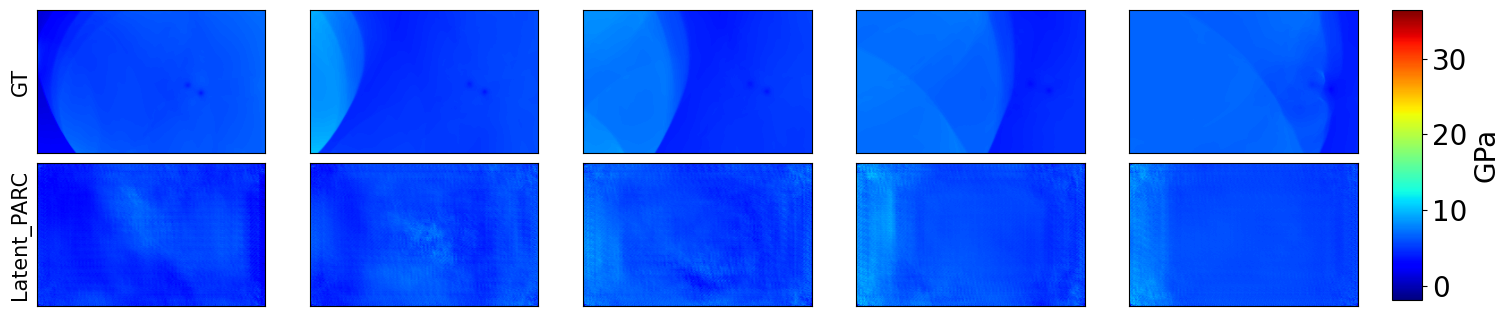

In [26]:
le_fig = plot_latent_prediction(pred, fields[f], 5)

In [85]:
ts_idx = 1
f = 0
fields = ['temperature', 'pressure', 'microstructure']
state_ae_v3 = PILE_v3(ts_idx+1, fields[f], 16, (160, 256, 3), [5, 2, 3])
enc = getattr(state_ae_v3, 'encoder_'+state_ae_v3.field)
dec = getattr(state_ae_v3, 'decoder_'+state_ae_v3.field)
evol = state_ae_v3.latent_evolution
enc.load_weights('../NN_weights/PILE_v3/' + state_ae_v3.field + '_encoder_' + str(ts_idx+1) + '_ts.h5')
dec.load_weights('../NN_weights/PILE_v3/' + state_ae_v3.field + '_decoder_' + str(ts_idx+1) + '_ts.h5')
evol.load_weights('../NN_weights/PILE_v3/' + state_ae_v3.field + '_evolution_' + str(ts_idx+1) + '_ts.h5')

In [86]:
# AE reconstruction
sample = 115
field_gt = np.moveaxis(state_traj[sample,:,:,f:f+1,:], [0,1,2,3], [1,2,3,0]) 
pred = state_ae_v3.predict(field_gt)
pred.shape

(2, 20, 160, 256)

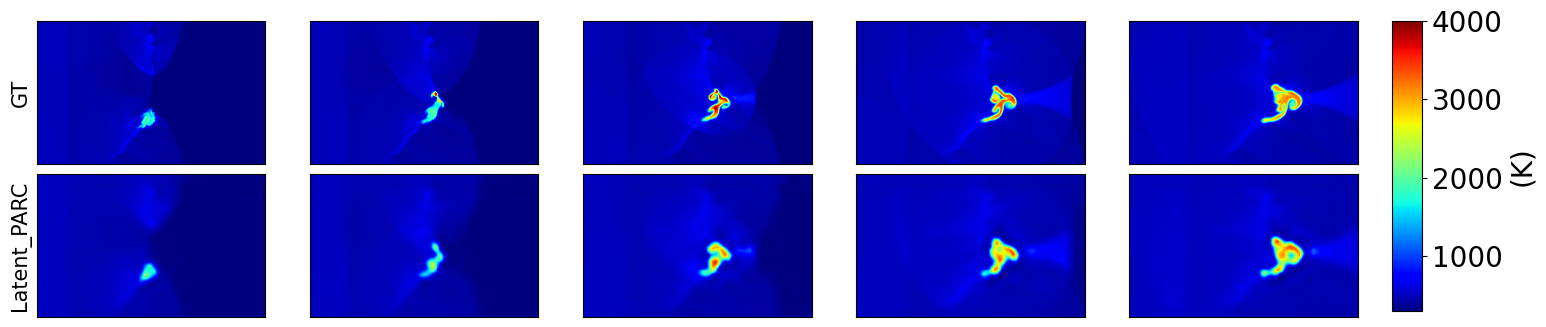

In [20]:
ae_fig = plot_latent_prediction(pred, fields[f], 5)

### Latent-PARC

In [12]:
latent_parc = LatentPARC_v2(3, 16, (160, 256, 3), [1, 1])
latent_state_traj = []
for t in range(state_traj.shape[4]):
    latent_state = []
    for i, field in enumerate(latent_parc.fields):
        latent_field = getattr(latent_parc, 'encoder_'+field)(state_traj[:,:,:, i:i+1, t])
        latent_state.append(latent_field)
    latent_state = np.concatenate(latent_state, axis=3)
    latent_state_traj.append(latent_state)
latent_state_traj = np.stack(latent_state_traj, axis=4)
latent_state_traj.shape

(119, 20, 32, 96, 20)

In [23]:
n_ts = 8
n_samples = 110
for ts_idx in range(n_ts):
    data_in = []
    data_out_1 = []
    data_out_2 = []
    for t in range (19-ts_idx):
        data_in.append(latent_state_traj[:n_samples,:,:,:,t:t+1])
        data_out_1.append(latent_state_traj[:n_samples,:,:,:,t+1:t+2+ts_idx])
        data_out_2.append(state_traj[:n_samples,:,:,:,t+1:t+2+ts_idx])
    data_in = np.concatenate(data_in, axis=0)
    data_out_1 = np.concatenate(data_out_1, axis=0)
    data_out_2 = np.concatenate(data_out_2, axis=0)
    
    ###
    latent_parc = LatentPARC_v2(ts_idx+1, 16, (160, 256, 3), [2, 1])
    if ts_idx > 0:
        latent_parc.latent_physics.load_weights('../NN_weights/Latent_PARC/latent_physics_' + str(ts_idx) + '_ts.h5')
        latent_parc.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.5,beta_2=0.99))
        latent_parc.fit([data_in], [data_out_1, data_out_2], batch_size = 16, epochs = 15, shuffle = True)
        latent_parc.latent_physics.save_weights('../NN_weights/Latent_PARC/latent_physics_' + str(ts_idx+1) + '_ts.h5')
    else:
        latent_parc.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.5,beta_2=0.99))
        latent_parc.fit([data_in], [data_out_1, data_out_2], batch_size = 16, epochs = 15, shuffle = True)
        latent_parc.latent_physics.save_weights('../NN_weights/Latent_PARC/latent_physics_' + str(ts_idx+1) + '_ts.h5')

Epoch 1/15


2024-01-28 20:14:27.923157: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f66057ec610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-28 20:14:27.923199: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-28 20:14:28.063080: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-28 20:14:29.187395: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


131/131 [==============================] - 12s 28ms/step - total_loss: 0.0826 - latent_loss: 0.0024 - recon_loss: 0.0778
Epoch 2/15
131/131 [==============================] - 2s 19ms/step - total_loss: 0.0408 - latent_loss: 0.0016 - recon_loss: 0.0376
Epoch 3/15
131/131 [==============================] - 2s 18ms/step - total_loss: 0.0354 - latent_loss: 0.0015 - recon_loss: 0.0324
Epoch 4/15
131/131 [==============================] - 2s 18ms/step - total_loss: 0.0329 - latent_loss: 0.0015 - recon_loss: 0.0300
Epoch 5/15
131/131 [==============================] - 2s 17ms/step - total_loss: 0.0308 - latent_loss: 0.0014 - recon_loss: 0.0280
Epoch 6/15
131/131 [==============================] - 2s 18ms/step - total_loss: 0.0294 - latent_loss: 0.0013 - recon_loss: 0.0268
Epoch 7/15
131/131 [==============================] - 2s 17ms/step - total_loss: 0.0290 - latent_loss: 0.0013 - recon_loss: 0.0263
Epoch 8/15
131/131 [==============================] - 2s 17ms/step - total_loss: 0.0280 - lat

2024-01-28 20:24:43.944541: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4541644800 exceeds 10% of free system memory.
2024-01-28 20:24:47.254905: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4541644800 exceeds 10% of free system memory.


Epoch 1/15
97/97 [==============================] - 25s 90ms/step - total_loss: 0.1406 - latent_loss: 0.0082 - recon_loss: 0.1241
Epoch 2/15
97/97 [==============================] - 8s 84ms/step - total_loss: 0.1402 - latent_loss: 0.0082 - recon_loss: 0.1238
Epoch 3/15
97/97 [==============================] - 8s 83ms/step - total_loss: 0.1406 - latent_loss: 0.0082 - recon_loss: 0.1241
Epoch 4/15
97/97 [==============================] - 8s 83ms/step - total_loss: 0.1397 - latent_loss: 0.0082 - recon_loss: 0.1233
Epoch 5/15
97/97 [==============================] - 8s 83ms/step - total_loss: 0.1388 - latent_loss: 0.0082 - recon_loss: 0.1225
Epoch 6/15
97/97 [==============================] - 8s 83ms/step - total_loss: 0.1387 - latent_loss: 0.0082 - recon_loss: 0.1223
Epoch 7/15
97/97 [==============================] - 8s 84ms/step - total_loss: 0.1388 - latent_loss: 0.0082 - recon_loss: 0.1225
Epoch 8/15
97/97 [==============================] - 8s 84ms/step - total_loss: 0.1377 - latent_l

2024-01-28 20:27:18.386565: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4920115200 exceeds 10% of free system memory.
2024-01-28 20:27:21.864665: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4920115200 exceeds 10% of free system memory.


Epoch 1/15
90/90 [==============================] - 26s 101ms/step - total_loss: 0.1615 - latent_loss: 0.0099 - recon_loss: 0.1418
Epoch 2/15
90/90 [==============================] - 8s 93ms/step - total_loss: 0.1620 - latent_loss: 0.0098 - recon_loss: 0.1423
Epoch 3/15
90/90 [==============================] - 9s 98ms/step - total_loss: 0.1597 - latent_loss: 0.0098 - recon_loss: 0.1400
Epoch 4/15
90/90 [==============================] - 9s 97ms/step - total_loss: 0.1601 - latent_loss: 0.0098 - recon_loss: 0.1405
Epoch 5/15
90/90 [==============================] - 9s 97ms/step - total_loss: 0.1601 - latent_loss: 0.0098 - recon_loss: 0.1405
Epoch 6/15
90/90 [==============================] - 8s 93ms/step - total_loss: 0.1601 - latent_loss: 0.0098 - recon_loss: 0.1405
Epoch 7/15
90/90 [==============================] - 9s 96ms/step - total_loss: 0.1605 - latent_loss: 0.0098 - recon_loss: 0.1410
Epoch 8/15
90/90 [==============================] - 9s 100ms/step - total_loss: 0.1574 - latent

2024-01-28 20:30:52.262093: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5190451200 exceeds 10% of free system memory.


Epoch 1/15
83/83 [==============================] - 29s 116ms/step - total_loss: 0.1822 - latent_loss: 0.0116 - recon_loss: 0.1590
Epoch 2/15
83/83 [==============================] - 9s 108ms/step - total_loss: 0.1827 - latent_loss: 0.0116 - recon_loss: 0.1596
Epoch 3/15
83/83 [==============================] - 9s 107ms/step - total_loss: 0.1822 - latent_loss: 0.0115 - recon_loss: 0.1591
Epoch 4/15
83/83 [==============================] - 9s 109ms/step - total_loss: 0.1808 - latent_loss: 0.0115 - recon_loss: 0.1577
Epoch 5/15
83/83 [==============================] - 9s 109ms/step - total_loss: 0.1806 - latent_loss: 0.0115 - recon_loss: 0.1575
Epoch 6/15
83/83 [==============================] - 9s 111ms/step - total_loss: 0.1808 - latent_loss: 0.0115 - recon_loss: 0.1577
Epoch 7/15
83/83 [==============================] - 9s 110ms/step - total_loss: 0.1835 - latent_loss: 0.0115 - recon_loss: 0.1605
Epoch 8/15
83/83 [==============================] - 9s 111ms/step - total_loss: 0.1782 - 

In [55]:
n_ts = 8
latent_parc = LatentPARC_v2(n_ts, 16, (160, 256, 3), [2, 1])
latent_parc.latent_physics.load_weights('../NN_weights/Latent_PARC/latent_physics_' + str(n_ts) + '_ts.h5')

In [165]:
sample = 114
init_step = 0
evol_step = 15
input_state_gt = state_traj[sample:sample+1, :,:,:,init_step]
pred, _ = latent_parc.predict(input_state_gt, evol_step)
pred.shape

(1, 160, 256, 3, 16)

In [166]:
visual_state = np.moveaxis(np.stack([np.squeeze(state_traj[sample:sample+1,:,:,:, init_step:init_step+evol_step+1]), np.squeeze(pred)], axis=0), [0, 1, 2, 3, 4], [0, 2, 3, 4, 1]) 
visual_state.shape

(2, 16, 160, 256, 3)

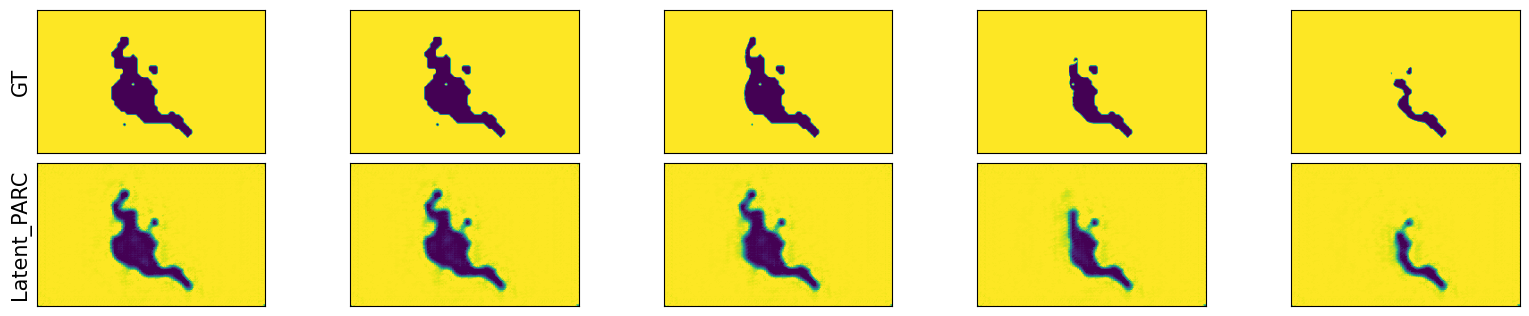

In [167]:
f = 2
fields = ['temperature', 'pressure', 'microstructure']
le_fig = plot_latent_prediction(visual_state[:,:,:,:,f], fields[f], 0)